# Relax Data Challenege

### Dependencies & data

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set()
%matplotlib inline

In [2]:
# Usage data
usage_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
print(usage_df.info())
usage_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [3]:
# User data
user_df = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'], encoding='latin-1')
print(user_df.info())
user_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB
None


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [4]:
# Rename `object_id` to `user_id`
user_df.rename(columns={'object_id': 'user_id'}, inplace=True)

# Convert `last_session_creation_time` to datetime
user_df['last_session_creation_time'] = pd.to_datetime(user_df.last_session_creation_time, unit='s')
user_df.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


### Label adopted users and count usage for each user

In [5]:
# Group visits by each user's weekly visits
weekly_usage_df = usage_df.groupby(['user_id', pd.Grouper(key='time_stamp', freq='7d')]).count()

# Filter for users who visited at least 3 times during any week
adopted_usage_df = weekly_usage_df[weekly_usage_df['visited'] >= 3]
adopted_users = adopted_usage_df.index.get_level_values(0).unique().values

print(len(adopted_users))
weekly_usage_df.head(2)

1445


,,visited
user_id,time_stamp,
1,2014-04-17,1
2,2013-11-14,1


In [6]:
# Create label for adopted users
user_df['adopted_user'] = np.where(user_df['user_id'].isin(adopted_users), 1, 0)
assert len(adopted_users) == user_df['adopted_user'].sum() # confirm equal length
user_df.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0


In [7]:
# Create a feature for the number of times each user logged in
usage_count_df = usage_df.groupby('user_id', as_index=False).sum()
user_df = user_df.merge(usage_count_df, on='user_id', how='left')
user_df['visited'] = user_df['visited'].fillna(0).astype(int)
user_df.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0,14


### Datetime EDA

In [8]:
# Create a feature for each user's first day of use
first_use = dict(usage_df.groupby('user_id')['time_stamp'].min())
user_df['first_use'] = user_df['user_id'].map(first_use)

# Create a feature for the number of days between account creation and first use
user_df['days_to_first_use'] = (user_df['first_use'] - user_df['creation_time']).dt.days
user_df['days_to_first_use'].fillna(999, inplace=True)
user_df.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,visited,first_use,days_to_first_use
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1,2014-04-22 03:53:30,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0,14,2013-11-15 03:45:04,0.0


In [9]:
# User adoption rate of users who login within the first n days
adoption_1d_df = user_df[user_df['days_to_first_use'] < 1]['adopted_user']
adoption_7d_df = user_df[user_df['days_to_first_use'] < 7]['adopted_user']
adoption_30d_df = user_df[user_df['days_to_first_use'] < 30]['adopted_user']
print(f'{adoption_1d_df.mean() * 100:.2f}% of users who login within the same DAY as creating an account are adopted users.')
print(f'{adoption_7d_df.mean() * 100:.2f}% of users who login within the same WEEK as creating an account are adopted users.')
print(f'{adoption_30d_df.mean() * 100:.2f}% of users who login within the same MONTH as creating an account are adopted users.')

17.22% of users who login within the same DAY as creating an account are adopted users.
16.42% of users who login within the same WEEK as creating an account are adopted users.
16.38% of users who login within the same MONTH as creating an account are adopted users.


In [10]:
# Check adoption rate of each signup month
monthly_adoption_df = user_df.groupby(pd.Grouper(key='creation_time', freq='M'))[['adopted_user']].mean().reset_index()
monthly_adoption_df['creation_time'] = monthly_adoption_df['creation_time'].dt.strftime('%Y-%m')
monthly_adoption_df.columns = ['creation_month', 'adoption_rate']
monthly_adoption_df

,creation_month,adoption_rate
0,2012-05,0.062500
1,2012-06,0.154613
2,2012-07,0.144703
3,2012-08,0.169863
4,2012-09,0.156479
5,2012-10,0.159601
6,2012-11,0.150246
7,2012-12,0.135922
8,2013-01,0.116331
9,2013-02,0.159705


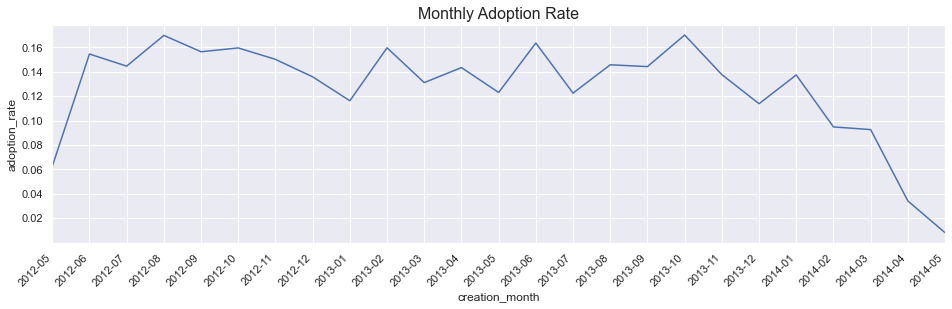

In [11]:
# Plot monthly adoption
plt.figure(figsize=(16, 4))
sns.lineplot(data=monthly_adoption_df, x='creation_month', y='adoption_rate')
plt.title('Monthly Adoption Rate', fontsize=16)
plt.xticks(ticks=range(monthly_adoption_df.shape[0]), labels=monthly_adoption_df['creation_month'], rotation=45, ha='right')
plt.xlim((0, monthly_adoption_df.shape[0] - 1));

### Categorical variables

In [12]:
# Simplify `invited_by_user_id` to a boolean feature that indicates whether the user was invited
user_df['invited'] = user_df['invited_by_user_id'].fillna(0).apply(lambda u: 1 if u > 0 else 0)
user_df.drop('invited_by_user_id', axis=1, inplace=True)

# Extract email domain
user_df['email_domain'] = user_df['email'].str.split('@').apply(lambda e: e[-1])

# Drop name and email
user_df.drop(['name', 'email'], axis=1, inplace=True)
user_df.head(2)

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,visited,first_use,days_to_first_use,invited,email_domain
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,0,1,2014-04-22 03:53:30,0.0,1,yahoo.com
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,0,14,2013-11-15 03:45:04,0.0,1,gustr.com


In [13]:
# Inspect email domains
email_domains = user_df['email_domain'].value_counts(ascending=False)
email_domains[email_domains > 1]

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
rerwl.com            2
oqpze.com            2
qgjbc.com            2
dqwln.com            2
mumdc.com            2
xybhi.com            2
xvnbr.com            2
luque.com            2
Name: email_domain, dtype: int64

In [14]:
# Group rare domains into a single category
common_domains = email_domains[email_domains > 2].index.values
user_df['email_domain'] = user_df['email_domain'].apply(lambda d: d if d in common_domains else 'other')
user_df['email_domain'].value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
other             1186
gustr.com         1179
hotmail.com       1165
Name: email_domain, dtype: int64

,adopted_user,visited
email_domain,,
cuvox.de,0.103993,13.729617
gmail.com,0.133352,20.019652
gustr.com,0.109415,16.547074
hotmail.com,0.157940,21.831760
jourrapide.com,0.117554,18.486100
other,0.123103,17.264755
yahoo.com,0.097262,12.836535


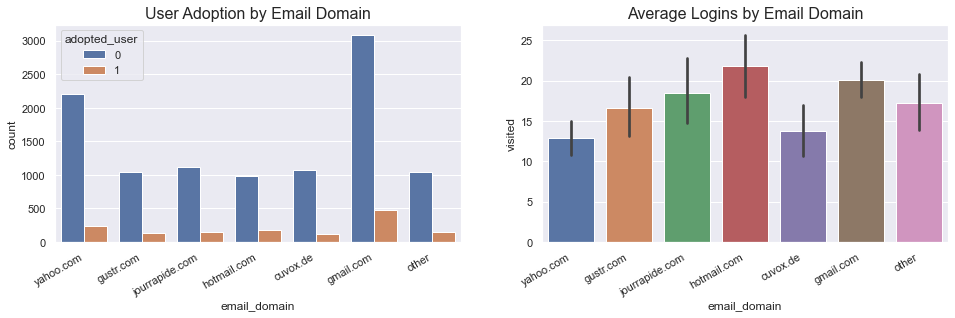

In [15]:
# User adoption and average logins by email domain
fig1, ax1 = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=user_df, x='email_domain', hue='adopted_user', ax=ax1[0])
sns.barplot(data=user_df, x='email_domain', y='visited', ax=ax1[1])
ax1[0].set_title('User Adoption by Email Domain', fontsize=16)
ax1[1].set_title('Average Logins by Email Domain', fontsize=16)
ax1[0].set_xticklabels(ax1[0].get_xticklabels(), rotation=30, ha='right')
ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation=30, ha='right')

user_df.groupby('email_domain')[['adopted_user', 'visited']].mean()

,adopted_user,visited
creation_source,,
GUEST_INVITE,0.152566,21.634767
ORG_INVITE,0.115891,16.476493
PERSONAL_PROJECTS,0.067740,9.105637
SIGNUP,0.130810,17.989938
SIGNUP_GOOGLE_AUTH,0.148736,24.738628


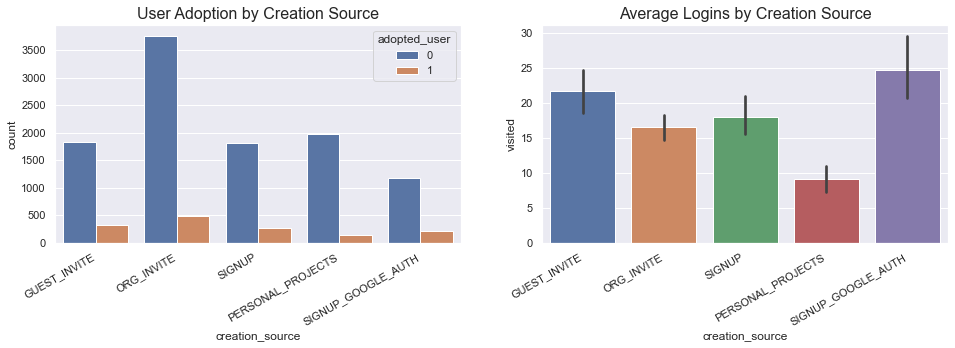

In [16]:
# User adoption and average logins by creation source
fig2, ax2 = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=user_df, x='creation_source', hue='adopted_user', ax=ax2[0])
sns.barplot(data=user_df, x='creation_source', y='visited', ax=ax2[1])
ax2[0].set_title('User Adoption by Creation Source', fontsize=16)
ax2[1].set_title('Average Logins by Creation Source', fontsize=16)
ax2[0].set_xticklabels(ax2[0].get_xticklabels(), rotation=30, ha='right')
ax2[1].set_xticklabels(ax2[1].get_xticklabels(), rotation=30, ha='right')

user_df.groupby('creation_source')[['adopted_user', 'visited']].mean()

In [17]:
# Group organizations with less than 15 accounts into 999 (to represent others)
org_users = user_df['org_id'].value_counts()
org_lt15u_idxs = org_users[org_users < 15].index.values
user_df['org_id'] = user_df['org_id'].apply(lambda i: 999 if i in org_lt15u_idxs else i)
len(org_lt15u_idxs), org_users[org_users < 15].sum()

(52, 613)

,adopted_user,visited
org_id,,
392,0.375000,42.437500
289,0.352941,59.882353
218,0.333333,60.291667
161,0.333333,71.000000
281,0.333333,41.444444
117,0.318182,65.500000
177,0.315789,43.631579
415,0.312500,43.375000
343,0.300000,62.150000


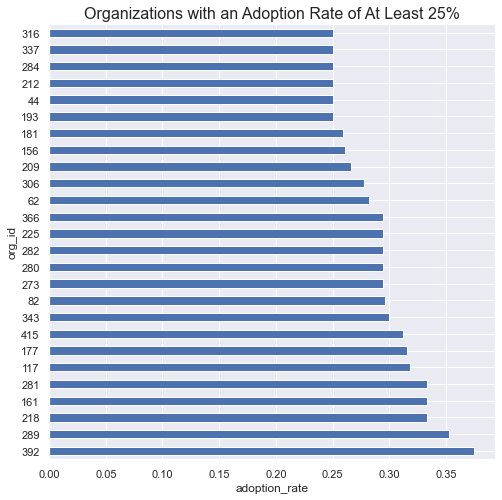

In [18]:
# Adoption rate by organization
org_adoption_df = user_df.groupby('org_id')[['adopted_user', 'visited']].mean().sort_values('adopted_user', ascending=False)
org_adoption_df[org_adoption_df['adopted_user'] >= 0.25]['adopted_user'].plot(kind='barh', figsize=(8, 8))
plt.title('Organizations with an Adoption Rate of At Least 25%', fontsize=16)
plt.xlabel('adoption_rate')

org_adoption_df[org_adoption_df['adopted_user'] >= 0.25]

### Encode categorical variables

In [19]:
# Create an organization-to-adoption-rate mapping
org_ar = dict(org_adoption_df['adopted_user'].sort_index())
print(len(org_ar))

# Encode `org_id` with their adoption rate
user_df['org_id'] = user_df['org_id'].map(org_ar)
user_df.head(2)

366


,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,visited,first_use,days_to_first_use,invited,email_domain
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,0.106667,0,1,2014-04-22 03:53:30,0.0,1,yahoo.com
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,0.055794,0,14,2013-11-15 03:45:04,0.0,1,gustr.com


In [20]:
# Encode creation_source
src_ar = user_df.groupby('creation_source')['adopted_user'].mean().to_dict()
print(len(src_ar))

# Encode `creation_source` with their adoption rate
user_df['creation_source'] = user_df.creation_source.map(src_ar)
user_df.head(2)

5


,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,visited,first_use,days_to_first_use,invited,email_domain
0,1,2014-04-22 03:53:30,0.152566,2014-04-22 03:53:30,1,0,0.106667,0,1,2014-04-22 03:53:30,0.0,1,yahoo.com
1,2,2013-11-15 03:45:04,0.115891,2014-03-31 03:45:04,0,0,0.055794,0,14,2013-11-15 03:45:04,0.0,1,gustr.com


In [21]:
# Encode email_domain
dom_ar = user_df.groupby('email_domain')['adopted_user'].mean().to_dict()
user_df['email_domain'] = user_df['email_domain'].map(dom_ar)
user_df.head(2)

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,visited,first_use,days_to_first_use,invited,email_domain
0,1,2014-04-22 03:53:30,0.152566,2014-04-22 03:53:30,1,0,0.106667,0,1,2014-04-22 03:53:30,0.0,1,0.097262
1,2,2013-11-15 03:45:04,0.115891,2014-03-31 03:45:04,0,0,0.055794,0,14,2013-11-15 03:45:04,0.0,1,0.109415


### Split data

In [22]:
# Select features
selected_cols = ['creation_source', 'email_domain', 'org_id', 'invited', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']
renamed_cols = ['creation_encoding', 'domain_encoding', 'org_encoding', 'invited', 'mailing_list', 'marketing_drip']

# Split data
X = user_df[selected_cols].copy()
X.columns = renamed_cols
y = user_df['adopted_user'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1666, random_state=0, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10000, 6), (2000, 6), (10000,), (2000,))

In [23]:
# Class (im)balance
print(y_train.mean())
y_train.value_counts()

0.1204


0    8796
1    1204
Name: adopted_user, dtype: int64

### Modeling 1

In [24]:
# Logistic regression
lr = LogisticRegression(max_iter=1e4, random_state=0)
lr.fit(X_train, y_train)
lr_pred_train = lr.predict(X_train)
lr_pred_test = lr.predict(X_test)

print('Train')
print('Accuracy:', lr.score(X_train, y_train))
print('ROC AUC:', roc_auc_score(y_train, lr_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train, lr_pred_train))

print('\nTest')
print('Accuracy:', lr.score(X_test, y_test))
print('ROC AUC:', roc_auc_score(y_test, lr_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, lr_pred_test))

Train
Accuracy: 0.8796
ROC AUC: 0.5
Confusion matrix:
 [[8796    0]
 [1204    0]]

Test
Accuracy: 0.8795
ROC AUC: 0.5
Confusion matrix:
 [[1759    0]
 [ 241    0]]


In [25]:
# Decision tree grid search
dt = DecisionTreeClassifier(random_state=0)
params = {'max_depth': range(2, 22, 2), 'min_samples_split': range(2, 22, 2), 'min_samples_leaf': range(2, 22, 2)}
gs = GridSearchCV(dt, params, scoring='roc_auc', cv=5, n_jobs=10)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)
gs.best_estimator_

0.6575354635252691
{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 14}


DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=14,
                       random_state=0)

In [26]:
# Decision tree
dt = gs.best_estimator_
dt.fit(X_train, y_train)
dt_pred_train = dt.predict(X_train)
dt_pred_test = dt.predict(X_test)

print('Train')
print('Score:', dt.score(X_train, y_train))
print('ROC AUC:', roc_auc_score(y_train, dt_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train, dt_pred_train))

print('\nTest')
print('Score:', dt.score(X_test, y_test))
print('ROC AUC:', roc_auc_score(y_test, dt_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, dt_pred_test))

Train
Score: 0.8799
ROC AUC: 0.5030380390361672
Confusion matrix:
 [[8791    5]
 [1196    8]]

Test
Score: 0.8795
ROC AUC: 0.5017904363805349
Confusion matrix:
 [[1758    1]
 [ 240    1]]


### Resample data

In [27]:
# Split data by label
train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train0 = train[train['adopted_user'] == 0]
train1 = train[train['adopted_user'] == 1]
train.shape, train0.shape, train1.shape

((10000, 7), (8796, 7), (1204, 7))

In [28]:
# Upsample positive labels
train1_resampled = train1.sample(train0.shape[0] // 2, replace=True)

# Combine training data
train_resampled = pd.concat([train0, train1_resampled])
train_resampled['adopted_user'].value_counts()

0    8796
1    4398
Name: adopted_user, dtype: int64

In [29]:
# Split features and label
X_train_resampled = train_resampled.drop('adopted_user', axis=1).copy()
y_train_resampled = train_resampled['adopted_user'].copy()
X_train_resampled.shape, y_train_resampled.shape

((13194, 6), (13194,))

### Modeling 2 (with resampled data)

In [30]:
# Logistic regression on resampled data
lr_resampled = LogisticRegression(max_iter=1e4, random_state=0)
lr_resampled.fit(X_train_resampled, y_train_resampled)
lr_resampled_pred_train = lr_resampled.predict(X_train_resampled)
lr_resampled_pred_test = lr_resampled.predict(X_test)

print('Train')
print('Accuracy:', lr_resampled.score(X_train_resampled, y_train_resampled))
print('ROC AUC:', roc_auc_score(y_train_resampled, lr_resampled_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train_resampled, lr_resampled_pred_train))

print('\nTest')
print('Accuracy:', lr_resampled.score(X_test, y_test))
print('ROC AUC:', roc_auc_score(y_test, lr_resampled_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, lr_resampled_pred_test))

Train
Accuracy: 0.688570562376838
ROC AUC: 0.5655411550704866
Confusion matrix:
 [[8221  575]
 [3534  864]]

Test
Accuracy: 0.845
ROC AUC: 0.5573753476489612
Confusion matrix:
 [[1647  112]
 [ 198   43]]


In [31]:
# Decision tree grid search
dt_resampled = DecisionTreeClassifier(random_state=0)
params_resampled = {'max_depth': range(2, 22, 2), 'min_samples_split': range(2, 22, 2), 'min_samples_leaf': range(2, 22, 2)}
gs_resampled = GridSearchCV(dt_resampled, params, scoring='roc_auc', cv=5, n_jobs=10)
gs_resampled.fit(X_train_resampled, y_train_resampled)

print(gs_resampled.best_score_)
print(gs_resampled.best_params_)
gs_resampled.best_estimator_

0.8495064518228167
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, random_state=0)

In [33]:
# Decision tree
dt_resampled = gs_resampled.best_estimator_
dt_resampled.fit(X_train_resampled, y_train_resampled)
dt_resampled_pred_train = dt_resampled.predict(X_train_resampled)
dt_resampled_pred_test = dt_resampled.predict(X_test)

print('Train')
print('Score:', dt_resampled.score(X_train_resampled, y_train_resampled))
print('ROC AUC:', roc_auc_score(y_train_resampled, dt_resampled_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train_resampled, dt_resampled_pred_train))

print('\nTest')
print('Score:', dt_resampled.score(X_test, y_test))
print('ROC AUC:', roc_auc_score(y_test, dt_resampled_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, dt_resampled_pred_test))

Train
Score: 0.8544035167500379
ROC AUC: 0.836118690313779
Confusion matrix:
 [[7837  959]
 [ 962 3436]]

Test
Score: 0.7375
ROC AUC: 0.5159558783635554
Confusion matrix:
 [[1421  338]
 [ 187   54]]


In [43]:
pd.DataFrame(np.array([X_train.columns.values, lr.coef_[0], tree.feature_importances_]).T, columns=['feature', 'lr_coef', 'dt_coef'])

,feature,lr_coef,dt_coef
0,creation_source,6.86582,0.0655019
1,email_domain,4.03902,0.228915
2,organization,8.00789,0.542852
3,invited,0.118942,0.0374294
4,mailing_list,0.127336,0.0777936
5,marketing_drip,-0.0894842,0.0475084


### Modeling 3 (with 3 features)

In [45]:
X_train_3 = X_train.drop(['invited', 'mailing_list', 'marketing_drip'], axis=1)
X_test_3 = X_test.drop(['invited', 'mailing_list', 'marketing_drip'], axis=1)
X_train_3.head()

,creation_source,email_domain,organization
0,0.115891,0.133352,0.105263
1,0.152566,0.097262,0.090909
2,0.130810,0.133352,0.077381
3,0.115891,0.117554,0.157895
4,0.115891,0.097262,0.161290


In [47]:
lr3 = LogisticRegression(max_iter=1e4)
lr3.fit(X_train_3, y_train)

print('Train')
print('Score:', lr3.score(X_train_3, y_train))
print('ROC AUC:', roc_auc_score(y_train, lr3.predict(X_train_3)))
print('Confusion matrix:\n', confusion_matrix(y_train, lr3.predict(X_train_3)))

print('\nTest')
print('Score:', lr3.score(X_test_3, y_test))
print('ROC AUC:', roc_auc_score(y_test, lr3.predict(X_test_3)))
print('Confusion matrix:\n', confusion_matrix(y_test, lr3.predict(X_test_3)))

Train
Score: 0.6898590268303775
ROC AUC: 0.5679854479308777
Confusion matrix:
 [[8212  584]
 [3508  890]]

Test
Score: 0.8475
ROC AUC: 0.5677487916323637
Confusion matrix:
 [[1647  112]
 [ 193   48]]


In [48]:
tree3 = DecisionTreeClassifier(random_state=0)
params = {'max_depth': range(4, 44, 4), 'min_samples_split': range(2, 12, 2), 'min_samples_leaf': range(1, 6, 1)}
gs3 = GridSearchCV(tree3, params, scoring='roc_auc', cv=5)
gs3.fit(X_train_3, y_train)
print(gs3.best_score_)
print(gs3.best_params_)

0.8369284302452096
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [49]:
tree3 = DecisionTreeClassifier(max_depth=20, random_state=0)
tree3.fit(X_train_3, y_train)

print('Train')
print('Score:', tree3.score(X_train_3, y_train))
print('ROC AUC:', roc_auc_score(y_train, tree3.predict(X_train_3)))
print('Confusion matrix:\n', confusion_matrix(y_train, tree3.predict(X_train_3)))

print('\nTest')
print('Score:', tree3.score(X_test_3, y_test))
print('ROC AUC:', roc_auc_score(y_test, tree3.predict(X_test_3)))
print('Confusion matrix:\n', confusion_matrix(y_test, tree3.predict(X_test_3)))

Train
Score: 0.8237835379718054
ROC AUC: 0.7982037289677127
Confusion matrix:
 [[7696 1100]
 [1225 3173]]

Test
Score: 0.751
ROC AUC: 0.5343733118826945
Confusion matrix:
 [[1442  317]
 [ 181   60]]


In [50]:
pd.DataFrame(np.array([X_train_3.columns.values, lr3.coef_[0], tree3.feature_importances_]).T, columns=['feature', 'lr_coef', 'dt_coef'])

,feature,lr_coef,dt_coef
0,creation_source,7.205,0.125151
1,email_domain,3.86543,0.262236
2,organization,8.00698,0.612613
